In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import numpy as np
from matplotlib import pyplot as plt
import os
from pathlib import Path
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch

In [13]:
class DiffFER(Dataset):
    def __init__(self, data):
        super().__init__()

        # everything in pytorch needs to be a tensor
        label_cols=['valence', 'arousal']
        self.labels = torch.tensor(data[label_cols].to_numpy(dtype=np.float32))
        self.inputs = torch.tensor(data.drop(label_cols, axis=1).to_numpy(dtype=np.float32))

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

    def __len__(self):
        return len(self.inputs)

In [14]:
path=Path(os.getcwd()).parent
DIR_PATH=str(path) + '\\'

In [95]:
dataset = pd.read_csv(DIR_PATH + r'data/extracted_df.csv')
#dataset.head(5)
cols=['AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU10', 'AU11',
       'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23', 'AU24', 'AU25', 'AU26',
       'AU28', 'AU43',  'valence', 'arousal']
data = dataset[cols]


In [97]:
len(dataset['valence'])

1285

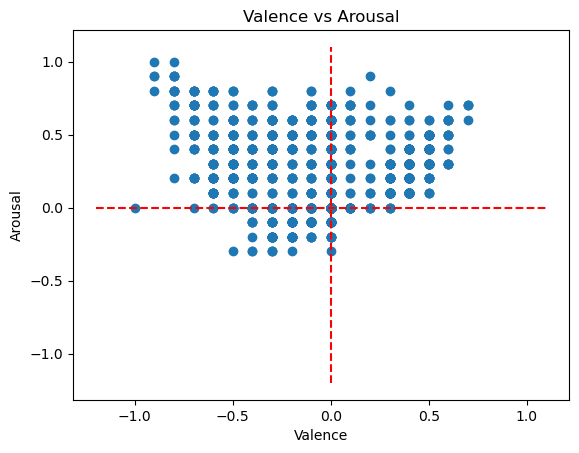

In [103]:
x1=[ 0*x/10 for x in range(-12,12,1)]
y1=[ x/10 for x in range(-12,12,1)]

x2=[ x/10 for x in range(-12,12,1)]
y2=[ 0*x/10 for x in range(-12,12,1)]

plt.title('Valence vs Arousal')
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.autoscale(enable=True, axis='x')
plt.scatter(dataset['valence'].values, dataset['arousal'].values, marker='o')
plt.plot(x1, y1, linestyle='--', color='r')
plt.plot(x2, y2, linestyle='--', color='r')
plt.show()

In [16]:
dataset.columns

Index(['AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU10', 'AU11',
       'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23', 'AU24', 'AU25', 'AU26',
       'AU28', 'AU43', 'anger', 'disgust', 'fear', 'happiness', 'sadness',
       'surprise', 'neutral', 'input', 'valence', 'arousal', 'expression'],
      dtype='object')

In [ ]:
# print("Unique classes", dataset["expression"].unique(), "\n")

# # see class balance
# def check(cl):
#     expression = {"anger": 0, "disgust": 1, "fear": 2, "happiness": 3, "neutral": 4, "sadness": 5, "surprise": 6}
#     for c,i in expression.items():
#         if cl==i:
#             return c
# check(1)
# daa={}
# counts=[]
# emos=[]
# for class0 in dataset["expression"].unique():
#     counts.append( (dataset['expression'] == class0).value_counts().iloc[1] )
#     emos.append(check(class0))
#     print(f"{(dataset['expression'] == class0).value_counts().iloc[1]}, {check(class0)}")
# daa['emos'] = emos
# daa['counts'] = counts
# print(daa)
# k= pd.DataFrame(daa)
# k.to_csv(DIR_PATH + 'scratch/daa.csv', index=False)

In [106]:
class MLP(nn.Module):
    def __init__(self, features_in=2, features_out=3):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(features_in, 20),
            nn.Linear(20, features_out)
            #nn.Linear(features_in, features_out)
        )
    def forward(self, input):
        return self.net(input)

In [107]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [54]:
dat=DiffFER(data)

# passing a generator to random_split is similar to specifying the seed in sklearn
generator = torch.Generator().manual_seed(2023)

# this can also generate multiple sets at the same time with e.g. [0.7, 0.2, 0.1]
train, test = random_split(dat, [0.7, 0.3], generator=generator)

train_loader = DataLoader(  # this loads the data that we need dynamically
    train,
    batch_size=16,  # instead of taking 1 data point at a time we can take more, making our training faster and more stable
    shuffle=True  # Shuffles the data between epochs (see below)
)

In [108]:
model = MLP(train[0][0].shape[0], dat.labels.shape[1])

optim = torch.optim.Adam(model.parameters(), lr=0.0001)

loss_fn = RMSELoss()

# Check if we have GPU acceleration, if we do our code will run faster
device = "cuda" if torch.cuda.is_available() else "cpu"
# if you are on mac with the new M1, M2, ... chips you can try the following instead of cuda
device = "mps" if torch.backends.mps.is_available() else device

print(f"Using device: {device}")

# we need to move our model to the correct device
model = model.to(device)

epochs=500

Using device: cuda


In [109]:
losses=[]
combined_acc=[]
for epoch in range(epochs):
    correct = 0
    n_correct=0
    for inputs, labels in train_loader:
        # both input, output and model need to be on the same device
        inputs = inputs.to(device)
        labels = labels.to(device)
        out = model(inputs)
        correct += torch.bitwise_and(out > 0, labels > 0).sum().cpu()
        n_correct += torch.bitwise_and(out < 0, labels < 0).sum().cpu()
        loss = loss_fn(out, labels)
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    combined_acc.append(100* (correct + n_correct)/(2*len(train)))
    print(f"epoch = {epoch}, RMSE = {loss}, combined acc: {100* (correct + n_correct)/(2*len(train))}")


epoch = 0, MAE = 0.30757975578308105, combined acc: 51.83333206176758
epoch = 1, MAE = 0.28324127197265625, combined acc: 50.83333206176758
epoch = 2, MAE = 0.33262065052986145, combined acc: 47.83333206176758
epoch = 3, MAE = 0.27928903698921204, combined acc: 50.0
epoch = 4, MAE = 0.28110289573669434, combined acc: 52.27777862548828
epoch = 5, MAE = 0.2623641788959503, combined acc: 55.77777862548828
epoch = 6, MAE = 0.22600112855434418, combined acc: 57.11111068725586
epoch = 7, MAE = 0.22895027697086334, combined acc: 57.83333206176758
epoch = 8, MAE = 0.2024526298046112, combined acc: 59.0
epoch = 9, MAE = 0.3050028681755066, combined acc: 59.27777862548828
epoch = 10, MAE = 0.3372344374656677, combined acc: 60.44444274902344
epoch = 11, MAE = 0.20759575068950653, combined acc: 60.66666793823242
epoch = 12, MAE = 0.2700069844722748, combined acc: 60.88888931274414
epoch = 13, MAE = 0.18312424421310425, combined acc: 61.0
epoch = 14, MAE = 0.2637665271759033, combined acc: 61.0
epo

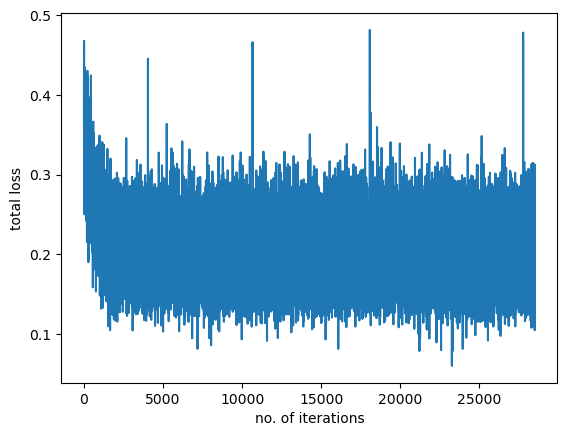

In [110]:
plt.plot(losses)
plt.xlabel("no. of iterations")
plt.ylabel("total loss")
plt.show()

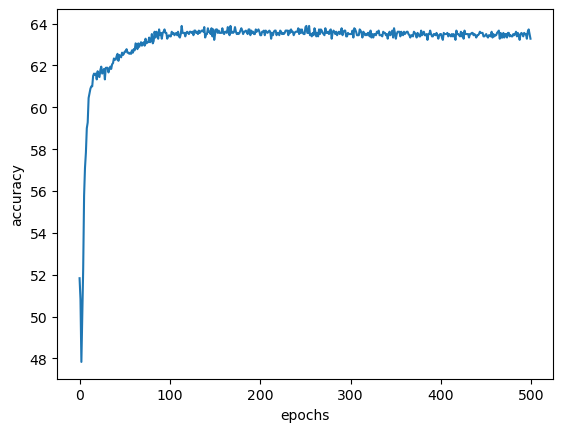

: 

In [111]:
plt.plot(combined_acc)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()